# Surrogate Modelling

The following tutorial demonstrates how one may perform surrogate modelling of a simulation model via `calisim`. We will first import our required dependencies.

In [1]:
from calisim.data_model import (
	DistributionModel,
	ParameterDataType,
	ParameterSpecification,
)
from calisim.example_models import SirOdesModel
from calisim.surrogate import (
	SurrogateModelMethod,
	SurrogateModelMethodModel,
)
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp

import warnings
warnings.filterwarnings("ignore")

## SIR Model Parameters and Initial Conditions

We next define our forward model. We will use an SIR (susceptible, infected, and recovered) compartmental model, combined with SciPy's solver for ordinary differential equations. The SIR model is expressed as a system of ordinary differential equations where:

| Parameter | Value | Description |
|-----------|-------|-------------|
| β (beta)  | 0.4   | Infection rate: probability of transmission per contact per time unit |
| γ (gamma) | 0.1   | Recovery rate: fraction of infected recovering per time unit |
|           |       | **Average infectious period = 1 / γ = 10 time units** |

With the following compartments:

| Compartment | Symbol | Initial Value | Description |
|------------|--------|---------------|-------------|
| Susceptible | S0     | 999           | Individuals who can catch the disease (N - I0 - R0) |
| Infected    | I0     | 1.0           | Individuals currently infected and can spread the disease |
| Recovered   | R0     | 0             | Individuals recovered or removed; no longer infectious |

In [2]:
def sir_simulate(parameters: dict) -> np.ndarray | pd.DataFrame:
    def dX_dt(_: np.ndarray, X: np.ndarray) -> np.ndarray:
        S, I, _ = X 
        dotS = -parameters["beta"] * S * I / parameters["N"]
        dotI = (
            parameters["beta"] * S * I / parameters["N"] - parameters["gamma"] * I
        )
        dotR = parameters["gamma"] * I
        return np.array([dotS, dotI, dotR])

    X0 = [parameters["S0"], parameters["I0"], parameters["R0"]]
    t = (parameters["t"].min(), parameters["t"].max())
    x_y = solve_ivp(
        fun=dX_dt, y0=X0, t_span=t, t_eval=parameters["t"].values.flatten()
    ).y

    df = pd.DataFrame(dict(dotS=x_y[0, :], dotI=x_y[1, :], dotR=x_y[2, :]))
    return df

We will perform a simulation study with the following ground-truth parameters:

In [3]:
model = SirOdesModel()
pd.DataFrame(model.GROUND_TRUTH, index=[0]) 

,beta,gamma,N,I0,R0,S0
0,0.4,0.1,1000,1.0,0,999.0


When supplied to our forward model, these ground-truth parameters will generate the observed data below:

In [4]:
observed_data = model.get_observed_data()
observed_data.head(6)

,dotS,dotI,dotR,day
0,999.000000,1.000000,0.000000,0
1,998.534208,1.349201,0.116592,1
2,997.906105,1.819995,0.273899,2
3,997.059813,2.454180,0.486007,3
4,995.919926,3.308098,0.771976,4
5,994.385263,4.457212,1.157524,5


Let's view the trajectory of infected individuals over time in days.

<Axes: xlabel='day', ylabel='dotI'>

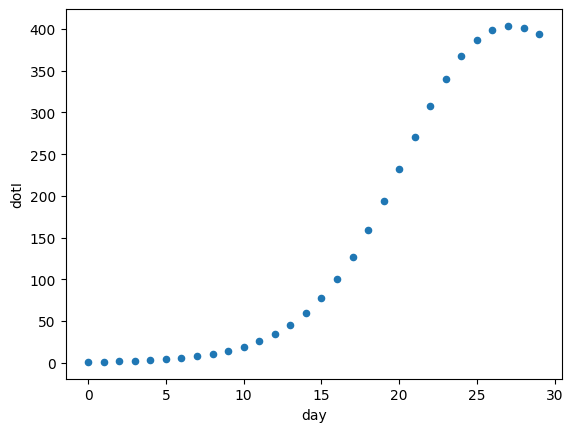

In [5]:
observed_data.plot.scatter("day", "dotI")

## Surrogate Modelling via Gaussian Processes

Next, let's use `calisim` to perform surrogate modelling using the end-of-simulation number of infections. 

To start with, we'll need to define our `ParameterSpecification` parameter specification:

In [6]:
parameter_spec = ParameterSpecification(
	parameters=[
		DistributionModel(
			name="beta",
			distribution_name="uniform",
			distribution_args=[0.3, 0.5],
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="gamma",
			distribution_name="uniform",
			distribution_args=[0.05, 0.15],
			data_type=ParameterDataType.CONTINUOUS,
		),
	]
)

This contains information concerning the various parameter names, probability distributions, ranges, distribution parameters, and data types.

We next need to create a wrapper function around our forward model to ensure there's compatibility with the `calisim` API.

In [7]:
def surrogate_modelling_func(
	parameters: dict, simulation_id: str, observed_data: np.ndarray | None, t: pd.Series
) -> float | list[float]:
    simulation_parameters = model.GROUND_TRUTH.copy()
    simulation_parameters["t"] = t
    
    for k in ["beta", "gamma"]:
        simulation_parameters[k] = parameters[k]
    
    simulated_data = sir_simulate(simulation_parameters).tail(1).dotI.item()
    return simulated_data

The last step is to create a `SurrogateModelMethodModel` specification for the surrogate modelling procedure itself, which we then supply to a `SurrogateModelMethod` calibrator. We'll use a `Gaussian process` surrogate model via the [scikit-learn engine](https://scikit-learn.org/).

In [8]:
specification = SurrogateModelMethodModel(
	experiment_name="sklearn_surrogate_modelling",
	parameter_spec=parameter_spec,
	method="gp",
	n_samples=50,
	output_labels=["Number of Infected"],
	calibration_func_kwargs=dict(t=observed_data.day),
)

calibrator = SurrogateModelMethod(
	calibration_func=surrogate_modelling_func,
	specification=specification,
	engine="sklearn",
)

Finally, we'll run the calibration procedure. This is composed of 3 steps:

1. **Specify**: Define your calibration problem: Parameter distributions, observed data, objective/discrepancy function, and calibration settings (like algorithm, directions, iterations)
2. **Execute**: Run the actual calibration process (simulation + optimization/inference)
3. **Analyze**: Process, summarize, and optionally save plots/metrics of the calibration results

Or **SEA**.

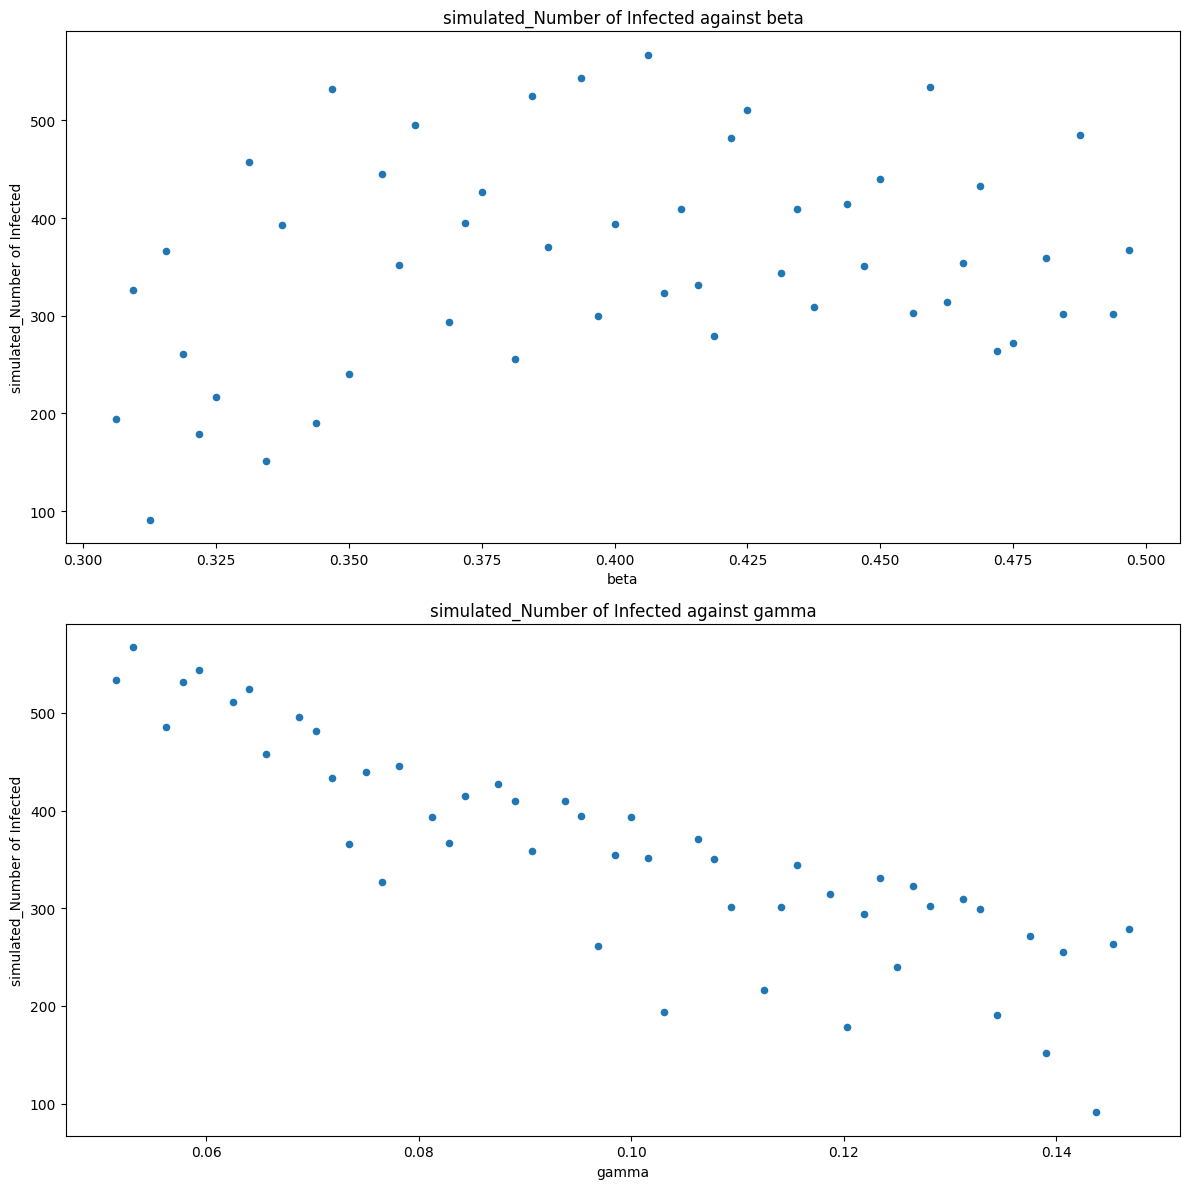

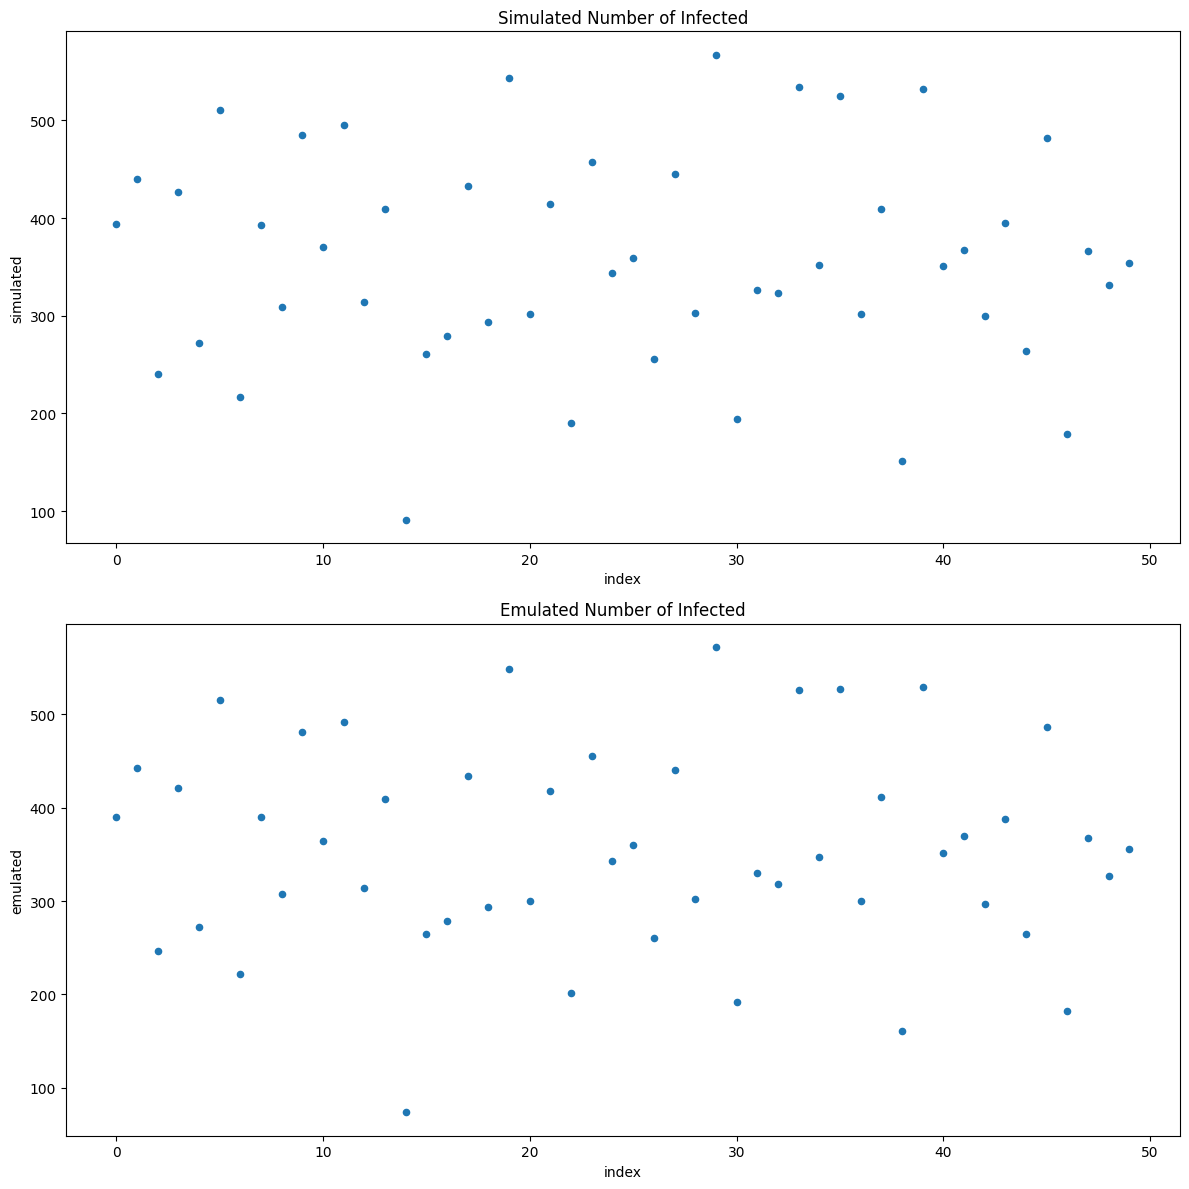

In [9]:
calibrator.specify().execute().analyze()

We can retrieve the surrogate model using the `get_emulator()` method. 

In [10]:
surrogate = calibrator.get_emulator()
surrogate

GaussianProcessRegressor()

We can generate new predictions by supplying the surrogate with newly sampled parameter values.

<Axes: xlabel='gamma', ylabel='Emulated Number of Infections'>

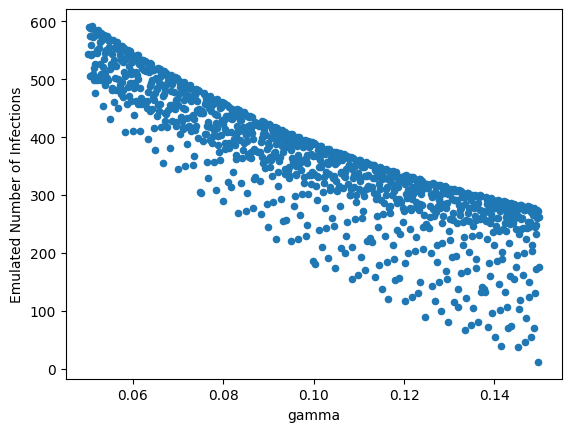

In [11]:
X = pd.DataFrame(calibrator.sample_parameters(1000), columns = ["beta", "gamma"])
X["Emulated Number of Infections"] = surrogate.predict(X)
X.plot.scatter("gamma", "Emulated Number of Infections")

There's a non-linear negative relationship between γ and the end-of-simulation number of infections, with greater variance as γ increases.

## Surrogate Modelling via Random Forest

We'll next demonstrate how to switch to another type of surrogate model using the same ` scikit-learn ` engine with minimal code changes. In this case, a `random forest` model.

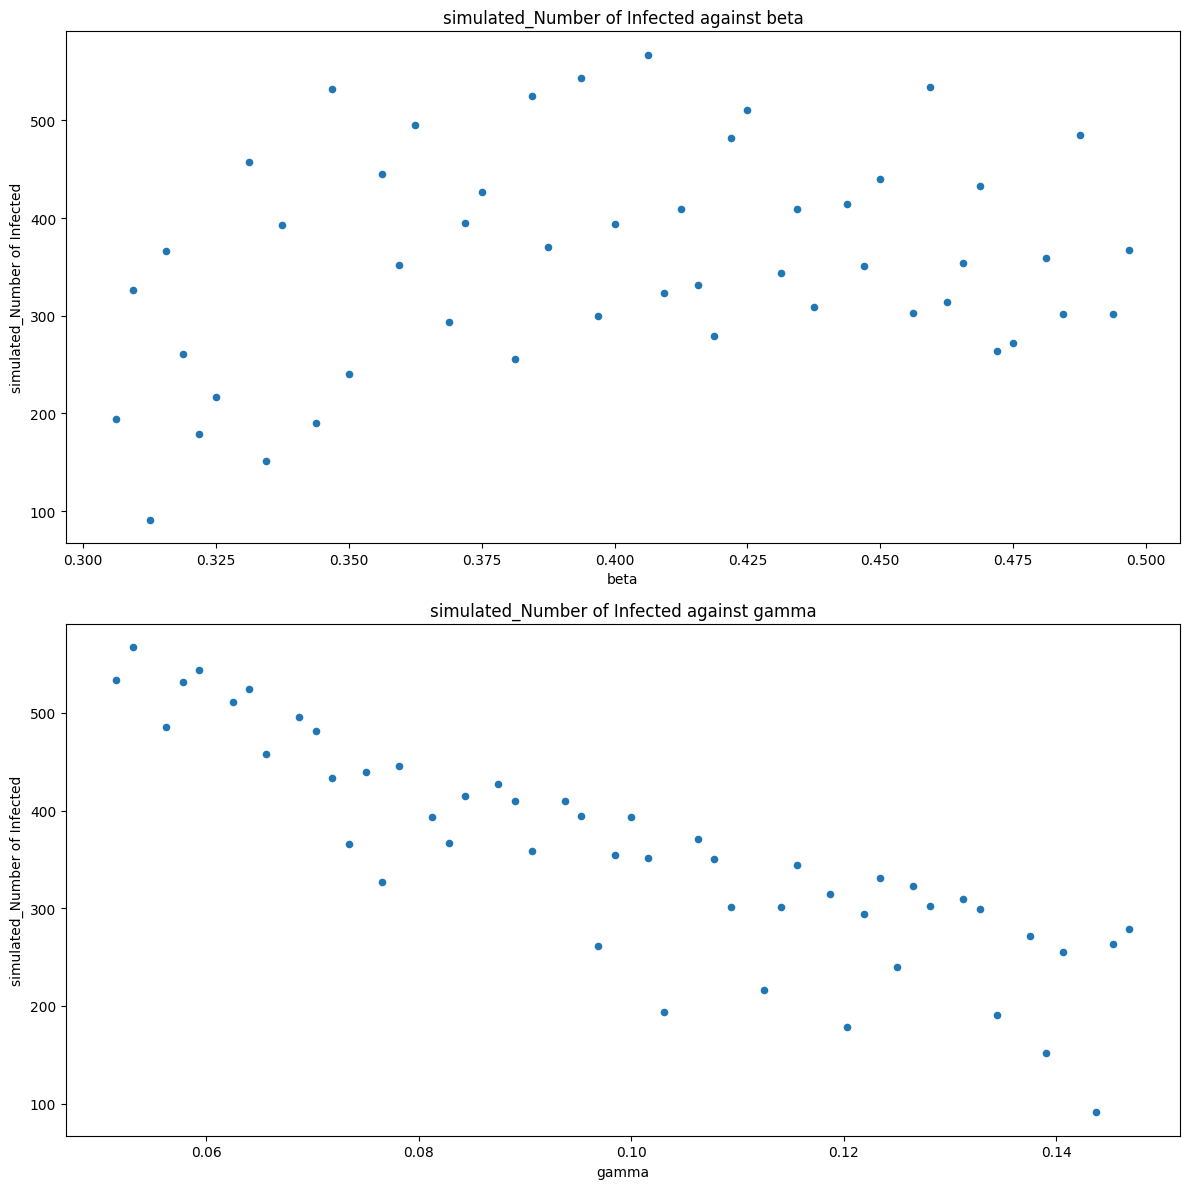

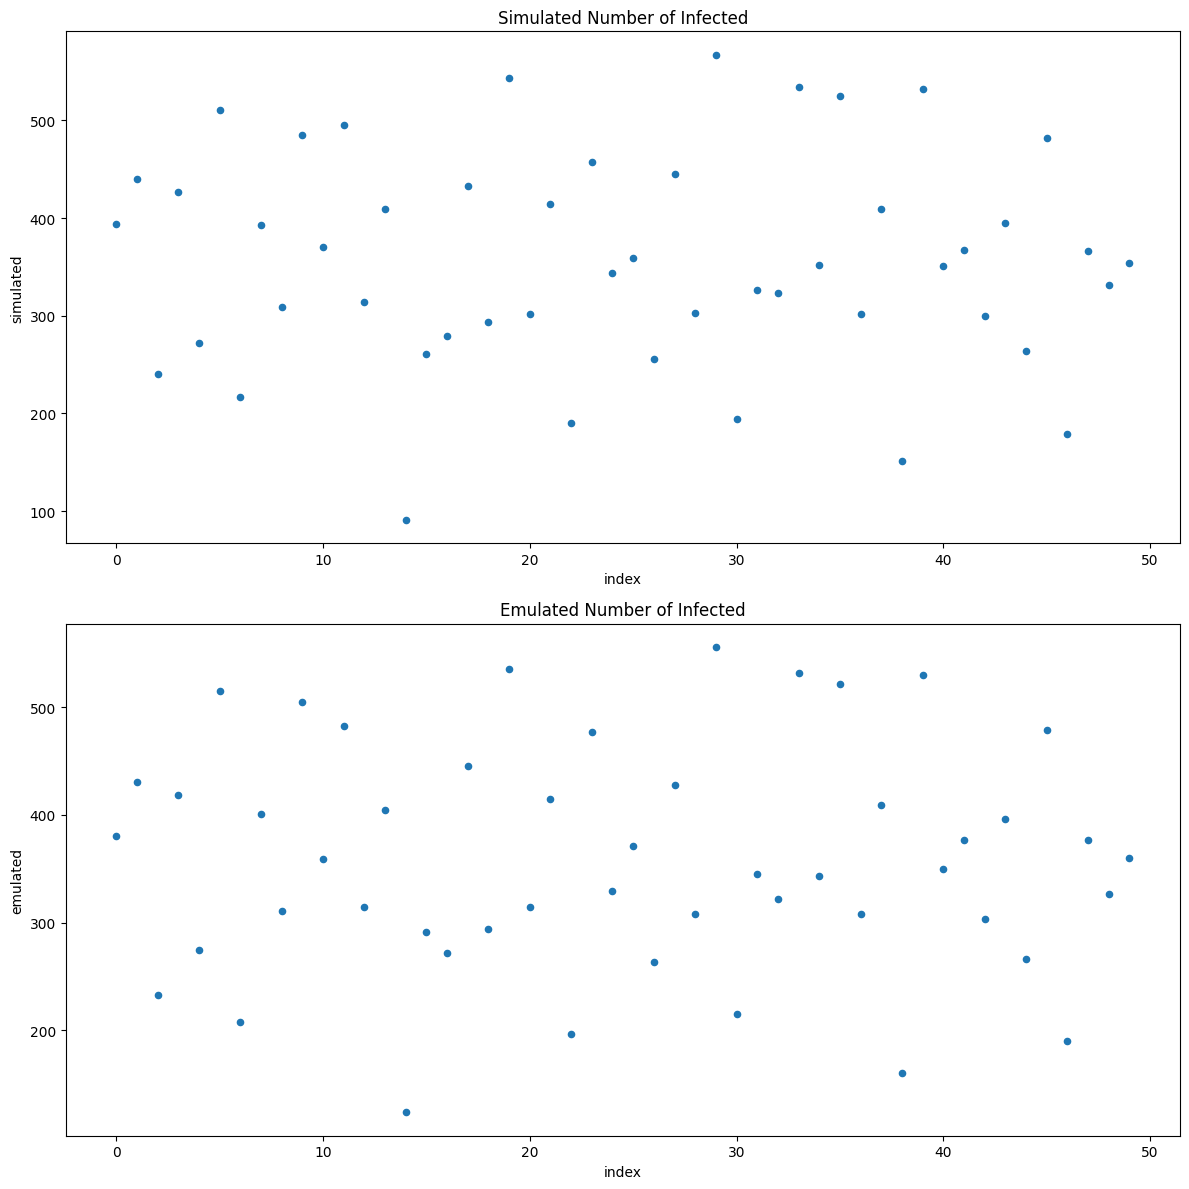

In [13]:
specification.method = "rf"

calibrator = SurrogateModelMethod(
	calibration_func=surrogate_modelling_func,
	specification=specification,
	engine="sklearn",
)

calibrator.specify().execute().analyze()

We can retrieve the random forest surrogate model using the `get_emulator()` method. 

In [14]:
surrogate = calibrator.get_emulator()
surrogate

RandomForestRegressor()

Again, we can generate new predictions by supplying the random forest model with newly sampled parameter values.

<Axes: xlabel='gamma', ylabel='Emulated Number of Infections'>

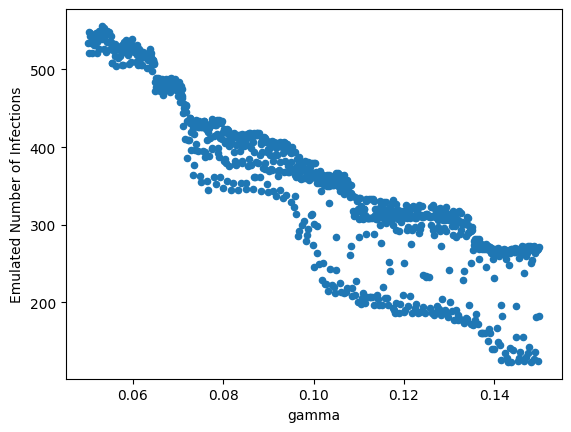

In [15]:
X = pd.DataFrame(calibrator.sample_parameters(1000), columns = ["beta", "gamma"])
X["Emulated Number of Infections"] = surrogate.predict(X)
X.plot.scatter("gamma", "Emulated Number of Infections")

There's a non-linear negative relationship between γ and the end-of-simulation number of infections, with greater variance as γ increases. When compared to the Gaussian process surrogate, the predictions appear forked and are not as smooth.